<a href="https://colab.research.google.com/github/gn1dus/mosi/blob/main/%D0%9B%D0%B0%D0%B1%D0%B0_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ДЗ 5
Найдем какие слова чаще используют в названиях книг!!

сначала мы делаем кластеризацию текстов через kmeans и нормализуем результаты через функцию активации

In [4]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
nltk.download('stopwords')

def linear_regression(df: pd.DataFrame) -> list[float]:
    vectorizer = TfidfVectorizer()
    vectors = vectorizer.fit_transform(df['clean_text'])
    kmeans = KMeans(n_clusters=5, random_state=42)
    clusters = kmeans.fit_predict(vectors)
    return clusters.tolist()

def activation_func(x: list[float]) -> list[float]:
    max_val = max(x) if max(x) != 0 else 1
    return [round(i / max_val, 2) for i in x]

def neuron(df: pd.DataFrame):
    temp_result = linear_regression(df)
    result = activation_func(temp_result)
    return result

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


тут мы считаем длину текстов находим самые частые слова и рисуем графики и облако слов чтобы посмотреть на распределение

In [29]:
def text_analysis(df):
    df['text_length'] = df['clean_text'].apply(lambda x: len(x.split()))

    all_words = ' '.join(df['clean_text']).split()
    word_freq = Counter(all_words)
    common_words = word_freq.most_common(20)

    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    sns.histplot(df['text_length'], bins=30)
    plt.title('ДЛИНА ТЕКСТА')

    plt.subplot(2, 2, 2)
    words, counts = zip(*common_words)
    sns.barplot(x=list(counts), y=list(words))
    plt.title('ТОП 20 САМЫХ ЧАСТЫХ СЛОВ')

    plt.subplot(2, 2, 3)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['clean_text']))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('ОБЛОКО СЛОВВ')

    plt.tight_layout()
    plt.show()

тут мы смотрим сколько текстов в каждом кластере считаем статистику и выводим топ слова для каждого кластера.я взял csv файл с названиям книг чтобы выяснить.... какие слова чащи используют для названия!!

In [30]:
def analyze_clusters(df):
    cluster_sizes = df['cluster'].value_counts().sort_index()

    cluster_stats = df.groupby('cluster').agg({
        'text_length': ['mean', 'median', 'count'],
    })

    vectorizer = TfidfVectorizer(max_features=5000)
    vectors = vectorizer.fit_transform(df['clean_text'])
    feature_names = vectorizer.get_feature_names_out()

    print("\nАнализ кластеров:")
    print("Размеры кластеров:")
    print(cluster_sizes)
    print("\nСтатистика по кластерам:")
    print(cluster_stats)

    kmeans = KMeans(n_clusters=5, random_state=42).fit(vectors)
    print("\nТоп слова по кластерам:")
    order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
    for i in range(5):
        print(f"\nКластер {i}:")
        top_words = [feature_names[ind] for ind in order_centroids[i, :10]]
        print(", ".join(top_words))

df = pd.read_csv('books.csv')
stop_words = set(stopwords.words('english'))

In [31]:
print(df.columns)


Index(['BOOKS', 'AUTHOR', 'PUBLISHERS'], dtype='object')


чистим текст от лишнего приводим к нижнему регистру убираем стоп слова потом применяем нейрон и смотрим насколько хорошо он кластеризует


In [33]:
df['text'] = df['BOOKS']

def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = text.split()
    filtered = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered)

df['clean_text'] = df['text'].apply(preprocess)
cluster_result = neuron(df)
df['cluster'] = cluster_result

print(df[['text', 'cluster']].head())


                                             text  cluster
0  Harry Potter and the Sorcerer's Stone (Book 1)     0.25
1         Harry Potter and the Chamber of Secrets     0.25
2          Harry Potter and the Half-Blood Prince     0.25
3        Harry Potter and the Prisoner of Azkaban     0.25
4       Harry Potter and the Order of the Phoenix     0.25


иии мы превращаем тексты в векторы с помощью tfidf а потом делим данные на train val и test чтобы дальше можно было обучать модели

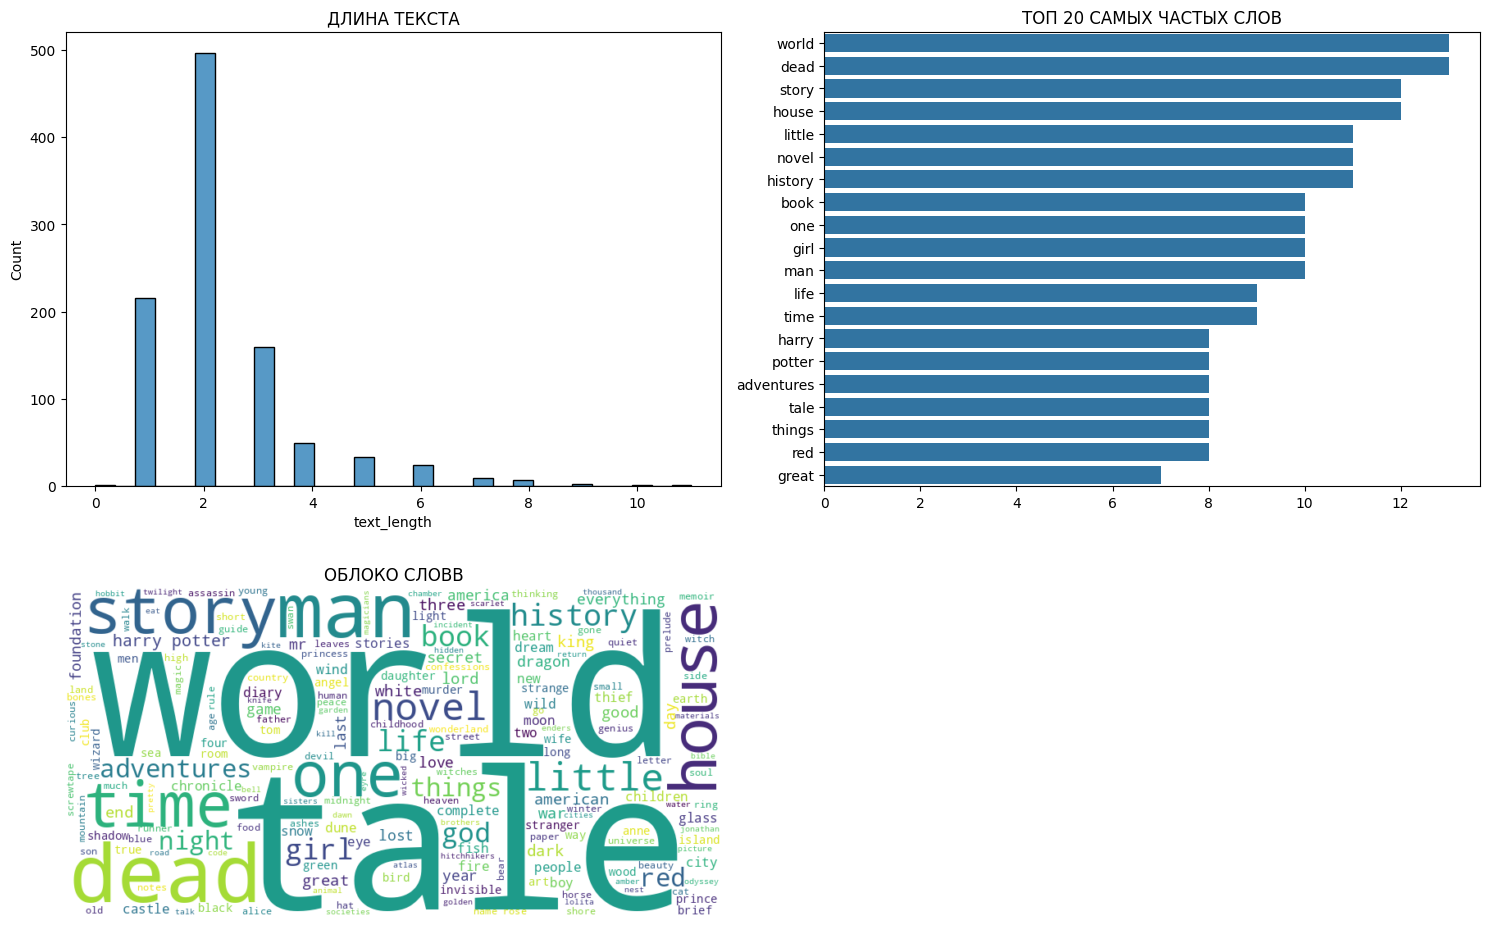

In [34]:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['clean_text'])
y = df['label'] if 'label' in df.columns else df['cluster']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
text_analysis(df)

In [35]:
analyze_clusters(df)


Анализ кластеров:
Размеры кластеров:
cluster
0.00      1
0.25    975
0.50      5
0.75     12
1.00      7
Name: count, dtype: int64

Статистика по кластерам:
        text_length             
               mean median count
cluster                         
0.00       1.000000    1.0     1
0.25       2.350769    2.0   975
0.50       2.000000    2.0     5
0.75       2.833333    2.0    12
1.00       2.571429    3.0     7

Топ слова по кластерам:

Кластер 0:
hatchet, foretold, forever, fortress, fortune, foucaults, foundation, foundations, fountainhead, four

Кластер 1:
dead, house, little, world, book, story, man, novel, girl, night

Кластер 2:
dune, heretics, messiah, children, emperor, god, forever, fortune, foucaults, foundation

Кластер 3:
red, dragon, fish, tent, mars, reborn, majestys, eyes, black, tattoo

Кластер 4:
moon, new, goodnight, fool, brave, harsh, mistress, hotel, trilogy, hampshire


тут мы видим что больше всего текстов попало в кластер 0.25 — целых 975 штук
остальные кластеры почти пустые — по 1, 5, 7 и 12 текстов
скорее всего модель плохо разделила данные и почти всё отнесла к одному кластеру, но по топ-словам видно что какие-то темы всё же различаются. нужно или больше данных или другую настройку кластера (типа n_clusters или фильтрация)

И под конец разбиваем на train, test и val выборки

In [43]:
print(f'\nРазмеры выборок:')
print(f'TRAIN(ОБУЧАЮЩ): {X_train.shape[0]}')
print(f'VAL(ВАЛИДАЦИОННАЯ): {X_val.shape[0]}')
print(f'TEST(ТЕСТОВАЯ): {X_test.shape[0]}')


Размеры выборок:
TRAIN(ОБУЧАЮЩ): 700
VAL(ВАЛИДАЦИОННАЯ): 150
TEST(ТЕСТОВАЯ): 150
